In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [10]:
custom_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def load_assign_rand_labels(training_size, testing_size):
    # Load MNIST dataset
    trainset = datasets.MNIST('data', train=True, download=True, transform=custom_transform)
    testset = datasets.MNIST('data', train=False, download=True, transform=custom_transform)

    # Assign random labels to the training set
    train_labels = torch.randint(0, 10, (len(trainset),), dtype=torch.long)
    trainset.targets = train_labels

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=training_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=testing_size, shuffle=True)

    return train_loader, test_loader

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.c1 = nn.Conv2d(1, 5, 5)
        self.c2 = nn.Conv2d(5, 16, 5)
        self.l1 = nn.Linear(16 * 5 * 5, 100)
        self.l2 = nn.Linear(100, 84)
        self.l3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.c2(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size()[0], -1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))

        x = self.l3(x)
        return x

In [12]:
training_size = 100
testing_size = 100
train_loader, test_loader = load_assign_rand_labels(training_size, testing_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 273204479.26it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 73908293.97it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 168717313.47it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15615187.51it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [15]:
def train_func(model, optimizer, train_data):
    model.train()
    corr = 0
    tr_lo = 0
    co = 0

    for batch_idx, (data, target) in enumerate(train_data):
        co += 1
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        tr_lo += loss.data
        pred = np.argmax(output.data, axis=1)
        corr += np.equal(pred, target.data).sum()

    tr_lo = (tr_lo * 100) / len(train_data.dataset)
    accuracy = 100.0 * corr / len(train_data.dataset)
    return tr_lo, accuracy


In [13]:
def test_func(model, epoch, test_data):
    model.eval()
    te_lo = 0
    corr = 0

    for data, target in test_data:
        data, target = Variable(data), Variable(target)
        output = model(data)
        loss = loss_fn(output, target)
        te_lo += loss.data
        pred = np.argmax(output.data, axis=1)
        corr += np.equal(pred, target.data).sum()

    te_lo = (te_lo * 100) / len(test_loader.dataset)
    print('\n. Epoch {}, Average loss is {:.5f}, Accuracy is {:.0f}%\n'.format(epoch, te_lo,
        100. * corr / len(test_data.dataset)))
    return te_lo


In [16]:
model = Model()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
train_loss_arr = []
test_loss_arr = []
epoch_arr = []
epochs = 100
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(1, epochs + 1):
    print('Training epoch - ', epoch)
    tr_loss, acc = train_func(model, optimizer, train_loader)
    train_loss_arr.append(tr_loss)
    loss_test = test_func(model, epoch, test_loader)
    test_loss_arr.append(loss_test)
    epoch_arr.append(epoch)

Training epoch -  1

. Epoch 1, Average loss is 2.29956, Accuracy is 12%

Training epoch -  2

. Epoch 2, Average loss is 2.29902, Accuracy is 15%

Training epoch -  3

. Epoch 3, Average loss is 2.29713, Accuracy is 11%

Training epoch -  4

. Epoch 4, Average loss is 2.29749, Accuracy is 11%

Training epoch -  5

. Epoch 5, Average loss is 2.29692, Accuracy is 13%

Training epoch -  6

. Epoch 6, Average loss is 2.29892, Accuracy is 9%

Training epoch -  7

. Epoch 7, Average loss is 2.30155, Accuracy is 8%

Training epoch -  8

. Epoch 8, Average loss is 2.30254, Accuracy is 10%

Training epoch -  9

. Epoch 9, Average loss is 2.30524, Accuracy is 9%

Training epoch -  10

. Epoch 10, Average loss is 2.30859, Accuracy is 8%

Training epoch -  11

. Epoch 11, Average loss is 2.31102, Accuracy is 8%

Training epoch -  12

. Epoch 12, Average loss is 2.30764, Accuracy is 9%

Training epoch -  13

. Epoch 13, Average loss is 2.30956, Accuracy is 8%

Training epoch -  14

. Epoch 14, Ave

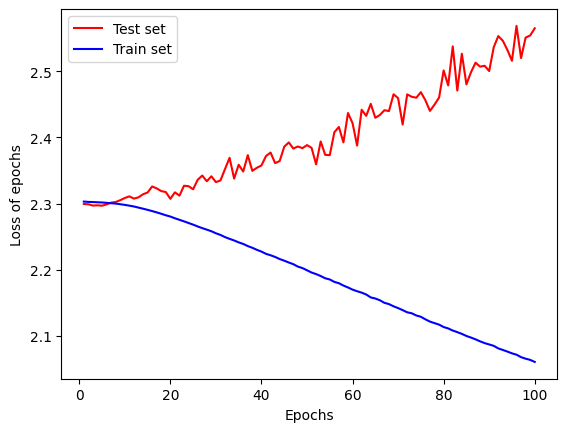

In [17]:
plt.plot(epoch_arr, test_loss_arr, color = "red")
plt.plot(epoch_arr, train_loss_arr, color = "blue")
plt.xlabel('Epochs')
plt.ylabel('Loss of epochs')
plt.legend(['Test set', 'Train set'])
plt.show()

In [18]:
model_param = Model()
param = sum(p.numel() for p in model.parameters())
print(param)

51580
